In [38]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

C:\Users\Terry_Xu\AppData\Local\Temp\ipykernel_29776\1659410565.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [39]:
df_ori = pd.read_csv('./data/close.csv', sep=',')
# df_ori['cash'] = 1
# df_ori = pd.read_csv('./data/close_390.csv', sep=',')
df_ori.head()

,Date,AAPL,AMZN,JNJ,JPM,LLY,MSFT,NVDA,PG,UNH,XOM
0,2003-11-18,0.364464,2.4250,51.939999,34.889999,70.940002,25.150000,1.639167,47.830002,24.549999,35.150002
1,2003-11-19,0.364643,2.4765,52.259998,34.759998,72.540001,25.350000,1.685000,48.040001,25.790001,35.439999
2,2003-11-20,0.363929,2.4425,51.490002,34.630001,71.529999,25.100000,1.640000,47.705002,25.400000,35.310001
3,2003-11-21,0.362143,2.4290,50.880001,35.000000,69.610001,25.110001,1.646667,47.880001,25.860001,35.340000
4,2003-11-24,0.377679,2.5665,51.480000,35.270000,70.500000,25.730000,1.745833,48.310001,26.400000,35.560001


In [40]:
df_ori.set_index('Date', inplace=True)
df_ori.index = pd.DatetimeIndex(df_ori.index)
ENDTIME = pd.to_datetime('2008-12-31')
df_ori = df_ori.loc[df_ori.index <= ENDTIME]
df_ori.tail()

,AAPL,AMZN,JNJ,JPM,LLY,MSFT,NVDA,PG,UNH,XOM
Date,,,,,,,,,,
2008-12-24,3.037143,2.572,58.560001,29.850000,37.799999,19.170000,1.9300,60.389999,25.959999,75.779999
2008-12-26,3.064643,2.589,58.560001,29.799999,37.980000,19.129999,1.8775,60.529999,26.299999,77.190002
2008-12-29,3.093214,2.470,58.150002,29.780001,38.480000,18.959999,1.9375,60.200001,25.570000,78.019997
2008-12-30,3.081786,2.538,59.169998,31.010000,39.669998,19.340000,2.0050,61.119999,27.040001,78.589996
2008-12-31,3.048214,2.564,59.830002,31.530001,40.270000,19.440001,2.0175,61.820000,26.600000,79.830002


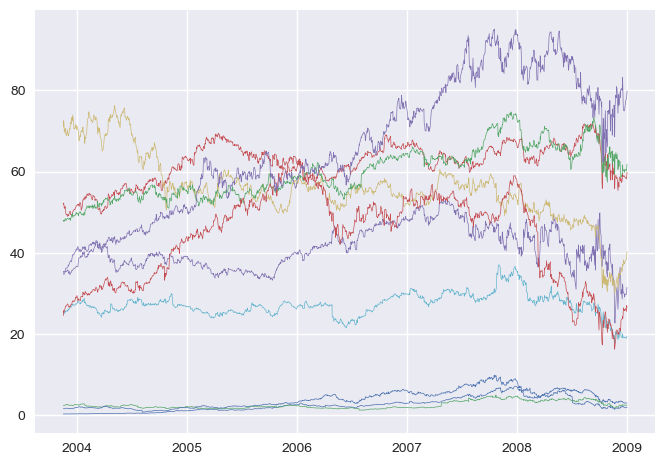

In [41]:
plt.figure()
for stk in df_ori.columns:
    plt.plot(df_ori.index, df_ori.loc[:,stk], linewidth=0.5, label=stk)
    # plt.legend(loc='best')

plt.show()

In [78]:

df = df_ori.pct_change().iloc[1:,:]
df['cash']=(1.1)**(1/252)-1
df.head()

,AAPL,AMZN,JNJ,JPM,LLY,MSFT,NVDA,PG,UNH,XOM,cash
Date,,,,,,,,,,,
2003-11-19,0.000491,0.021237,0.006161,-0.003726,0.022554,0.007952,0.027961,0.004391,0.050509,0.008250,0.000378
2003-11-20,-0.001958,-0.013729,-0.014734,-0.003740,-0.013923,-0.009862,-0.026706,-0.006973,-0.015122,-0.003668,0.000378
2003-11-21,-0.004908,-0.005527,-0.011847,0.010684,-0.026842,0.000398,0.004065,0.003668,0.018110,0.000850,0.000378
2003-11-24,0.042900,0.056608,0.011792,0.007714,0.012786,0.024691,0.060222,0.008981,0.020882,0.006225,0.000378
2003-11-25,-0.022223,0.022209,-0.015346,0.007372,0.002411,-0.012825,0.017184,0.002587,0.019508,0.007312,0.000378


In [43]:
df = df.dropna(axis=1)
df.isnull().sum().sum()

0

In [79]:
df.head()

,AAPL,AMZN,JNJ,JPM,LLY,MSFT,NVDA,PG,UNH,XOM,cash
Date,,,,,,,,,,,
2003-11-19,0.000491,0.021237,0.006161,-0.003726,0.022554,0.007952,0.027961,0.004391,0.050509,0.008250,0.000378
2003-11-20,-0.001958,-0.013729,-0.014734,-0.003740,-0.013923,-0.009862,-0.026706,-0.006973,-0.015122,-0.003668,0.000378
2003-11-21,-0.004908,-0.005527,-0.011847,0.010684,-0.026842,0.000398,0.004065,0.003668,0.018110,0.000850,0.000378
2003-11-24,0.042900,0.056608,0.011792,0.007714,0.012786,0.024691,0.060222,0.008981,0.020882,0.006225,0.000378
2003-11-25,-0.022223,0.022209,-0.015346,0.007372,0.002411,-0.012825,0.017184,0.002587,0.019508,0.007312,0.000378


In [80]:
def equally_weighted(df):
    arr_pfl = [1]
    cur_pfl = 1
    cur_stg = np.array([1 / len(df.columns)] * len(df.columns))
    # print(cur_stg)

    for i in range(len(df)):
        cur_pfl = cur_pfl * np.dot(cur_stg, 1 + df.iloc[i,:].values)
        arr_pfl.append(cur_pfl)

    return arr_pfl

arr_equal = equally_weighted(df)

In [10]:
test_df=pd.DataFrame({'A':[2,0.5,2,0.5],"B":[0.5,2,0.5,2],"C":[1,2,3,4]})
test_df

,A,B,C
0,2.0,0.5,1
1,0.5,2.0,2
2,2.0,0.5,3
3,0.5,2.0,4


In [81]:
#Best constant rebalanced portfolio in hindsight
def BCRP(df):
    x=cp.Variable(len(df.columns),nonneg=True)
    objective=cp.Maximize(cp.sum(cp.log(1+df.values@x)))
    constrains=[cp.sum(x)<=1]
    problem=cp.Problem(objective,constrains)
    result=problem.solve(solver=cp.ECOS)
    weight=x.value
    arr_pfl = [1]
    cur_pfl = 1
    for i in range(len(df)):
        cur_pfl = cur_pfl * np.dot(weight, 1 + df.iloc[i,:].values)
        arr_pfl.append(cur_pfl)
    return weight,arr_pfl
weight_BCRP,arr_BCRP=BCRP(df)
weight_BCRP

array([1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.30294434e-13, 0.00000000e+00,
       0.00000000e+00, 2.07463223e-12, 1.28306601e-13])

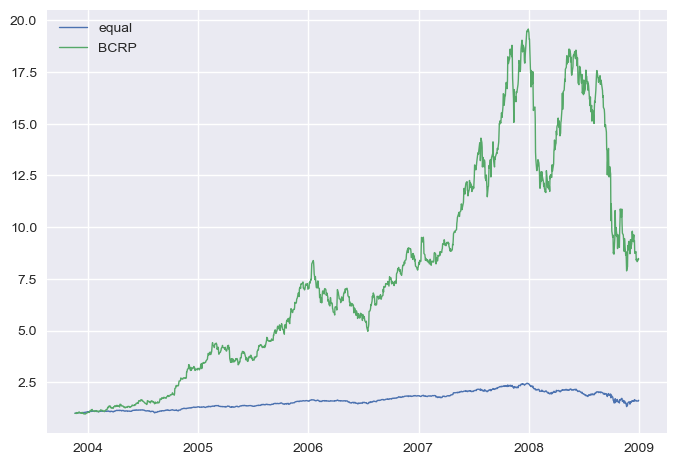

In [82]:
plt.figure()
# plt.plot(df.index, arr_pfl[:-1], linewidth=0.5, label='OGD')
plt.plot(df.index, arr_equal[:-1], linewidth=1, label='equal')
plt.plot(df.index, arr_BCRP[:-1], linewidth=1, label='BCRP')
plt.legend(loc='best')
plt.show()

In [31]:
len(arr_BCRP)

2

In [83]:
# begin OGD process
# import math

def OGD_update(x_old, ETA, loss, num_of_var):
    x = cp.Variable(num_of_var, nonneg=True)
    # x = cp.Variable(num_of_var, nonneg=False)
    objective = cp.Minimize(ETA * np.array(loss) @ x + 0.5 * cp.sum((x - x_old) ** 2))
    constraints = [cp.sum(x) == 1]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()

    return x.value

def OGD_algo(df, ETA):
    arr_pfl = [1]
    cur_pfl = 1
    cur_stg = np.array([1/len(df.columns)] * len(df.columns))
    last_stg = np.array([1/len(df.columns)] * len(df.columns))
    # cur_stg = np.array([0] * len(df.columns))
    # last_stg = np.array([0] * len(df.columns))
    arr_stg = [cur_stg]
    COMMISSION = 1e-3
    # RSKFREE = 1.02 ** (1/365)
    ret=[1]
    weight=[sum(cur_stg)]

    for i in tqdm(range(len(df))):
        # return of today
        commision_rate = np.sum(np.abs(cur_stg - last_stg)) * COMMISSION
        cur_ret=np.dot(cur_stg, 1 + df.iloc[i,:].values)
        cur_pfl = cur_pfl * (cur_ret - commision_rate)
        ret.append(cur_ret)
        weight.append(np.sum(cur_stg))

        arr_pfl.append(cur_pfl)
        # define the loss: linear -retn * x
        # direction = -1 * df.iloc[i,:].values
        direction = -1 * np.log(np.array(df.iloc[i,:].values)+1)
        # OGD to find strategy in the next round
        last_stg = cur_stg.copy()
        cur_stg = OGD_update(cur_stg, ETA, direction, len(df.columns))
        arr_stg.append(cur_stg)

    return arr_pfl , arr_stg, ret, weight

ETA = 0.2
arr_pfl_OGD , arr_stg_OGD , ret_OGD, weight_OGD= OGD_algo(df, ETA)

  0%|          | 0/1288 [00:00<?, ?it/s]

100%|██████████| 1288/1288 [00:13<00:00, 96.11it/s] 


In [84]:
# begin OMD process
# import math

def OMD_update(x_old, loss, num_of_var, A):
    x = cp.Variable(num_of_var, nonneg=True)
    # x = cp.Variable(num_of_var, nonneg=False)
    delta=x-x_old
    objective = cp.Minimize(np.array(loss) @ x + 0.5 * (delta.T @ A @ delta))
    constraints = [cp.sum(x) == 1]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()

    return x.value

def OMD_algo(df):
    arr_pfl = [1]
    cur_pfl = 1
    cur_stg = np.array([1/len(df.columns)] * len(df.columns))
    last_stg = np.array([1/len(df.columns)] * len(df.columns))
    # cur_stg = np.array([0] * len(df.columns))
    # last_stg = np.array([0] * len(df.columns))
    arr_stg = [cur_stg]
    COMMISSION = 1e-3
    # RSKFREE = 1.02 ** (1/365)
    ret=[1]
    weight=[sum(cur_stg)]

    for i in tqdm(range(len(df))):
        # return of today
        commision_rate = np.sum(np.abs(cur_stg - last_stg)) * COMMISSION
        cur_ret=np.dot(cur_stg, 1 + df.iloc[i,:].values)
        cur_pfl = cur_pfl * (cur_ret - commision_rate)
        ret.append(cur_ret)
        weight.append(np.sum(cur_stg))

        arr_pfl.append(cur_pfl)
        # define the loss: linear -retn * x
        # direction = -1 * df.iloc[i,:].values
        direction = -1 * np.log(np.array(df.iloc[i,:].values)+1)
        # OMD to find strategy in the next round
        a=0.2+cur_stg
        A=np.diag(a)
        last_stg = cur_stg.copy()
        
        cur_stg = OMD_update(cur_stg, direction, len(df.columns),A)
        arr_stg.append(cur_stg)

    return arr_pfl , arr_stg, ret, weight


arr_pfl_OMD , arr_stg_OMD , ret_OMD, weight_OMD= OMD_algo(df)

100%|██████████| 1288/1288 [00:12<00:00, 101.12it/s]


In [ ]:

# Donot use up, It need lots of time 
# df_num=df.values
# df_num=(1+df_num)
# df_num
# import itertools
# #universal portfolio(up)
# def binnings(n, k, cache={}):
#     if n == 0:
#         return np.zeros((1, k))
#     if k == 0:
#         return np.empty((0, 0))
#     args = (n, k)
#     if args in cache:
#         return cache[args]
#     a = binnings(n - 1, k, cache)
#     a1 = a + (np.arange(k) == 0)
#     b = binnings(n, k - 1, cache)
#     b1 = np.hstack((np.zeros((b.shape[0], 1)), b))
#     result = np.vstack((a1, b1))
#     cache[args] = result
#     return result

# def portfolio_wealth(b, stock_data):
#     return np.prod(np.dot(stock_data,b))

# def up_algo(df):
#     arr_pfl = [1]
#     cur_pfl = 1
#     cur_stg = np.array([1/len(df.columns)] * len(df.columns))
#     last_stg = np.array([1/len(df.columns)] * len(df.columns))
#     arr_stg = [cur_stg]
#     COMMISSION = 1e-3
#     ret=[1]
#     weight=[sum(cur_stg)]
#     allocation_granularity = 20
#     all_portfolio_allocations = binnings(allocation_granularity, len(df.columns))
#     row_sums = all_portfolio_allocations.sum(axis=1)
#     all_portfolios = all_portfolio_allocations / row_sums[:,np.newaxis]
#     for i in tqdm(range(len(df))):
#         commision_rate = np.sum(np.abs(cur_stg - last_stg)) * COMMISSION
#         current_ret=np.dot(cur_stg, df_num[i,:])- commision_rate
#         cur_pfl = cur_pfl * (current_ret- commision_rate)
#         ret.append(current_ret)
#         weight.append(np.sum(cur_stg))
#         arr_pfl.append(cur_pfl)
#         last_stg = cur_stg.copy()
#         #update
#         portfolio_weights = np.array([portfolio_wealth(x, df_num[:i,:]) for x in list(all_portfolios)])
#         weighted_portfolio = np.dot(portfolio_weights, all_portfolios)
#         cur_stg = weighted_portfolio / np.sum(portfolio_weights)

#         arr_stg.append(cur_stg)
#     return arr_pfl , arr_stg, ret, weight

        
# arr_pfl_up , arr_stg_up , ret_up, weight_up= up_algo(df)     

In [85]:
#buy and hold
def buy_and_hold(df_ori):
    arr_pfl = [1]
    stg = np.array([1/len(df_ori.columns)] * len(df_ori.columns))
    units=stg/df_ori.iloc[1,:].values
    for i in range(2,len(df_ori)):
        cur_pfl=df_ori.iloc[i,:].values@units
        arr_pfl.append(cur_pfl)
    return arr_pfl

arr_pfl_BH=buy_and_hold(df_ori)
    


In [86]:
# EG algorithm
def EG_update(x_old,loss,ETA):
    x=np.multiply(x_old,np.exp(-1*loss*ETA)/np.dot(x_old,np.exp(-1*loss*ETA)))
    return x
                  
def EG_algo(df):
    arr_pfl = [1]
    cur_pfl = 1
    cur_stg = np.array([1/len(df.columns)] * len(df.columns))
    last_stg = np.array([1/len(df.columns)] * len(df.columns))
    # cur_stg = np.array([0] * len(df.columns))
    # last_stg = np.array([0] * len(df.columns))
    arr_stg = [cur_stg]
    COMMISSION = 1e-3
    ret=[1]
    weight=[sum(cur_stg)]
    ETA=1.2

    for i in tqdm(range(len(df))):
        # return of today
       
        commision_rate = np.sum(np.abs(cur_stg - last_stg)) * COMMISSION
        cur_pfl = cur_pfl * (np.dot(cur_stg, 1 + df.iloc[i,:].values) - commision_rate)
        ret.append(np.dot(cur_stg, 1 + df.iloc[i,:].values) - commision_rate)
        weight.append(np.sum(cur_stg))

        arr_pfl.append(cur_pfl)
        # define the loss: linear -retn * x
        # direction = -1 * df.iloc[i,:].values
        direction = -1 * np.log(np.array(df.iloc[i,:].values)+1)
        last_stg = cur_stg.copy()
        
        cur_stg = EG_update(cur_stg, direction, ETA)
        arr_stg.append(cur_stg)

    return arr_pfl , arr_stg, ret, weight
arr_pfl_EG , arr_stg_EG , ret_EG, weight_EG= EG_algo(df)  

100%|██████████| 1288/1288 [00:00<00:00, 2224.49it/s]


In [99]:
#RM algorithms
def RM_update(regret_old,x_old,loss):
    regret=regret_old+(np.dot(loss,x_old)-loss)
    x=np.maximum(regret,0)/np.sum(np.maximum(regret,0))
    return regret, x

def RM_algo(df):
    arr_pfl = [1]
    cur_pfl = 1
    cur_stg = np.array([1/len(df.columns)] * len(df.columns))
    last_stg = np.array([1/len(df.columns)] * len(df.columns))
    # cur_stg = np.array([0] * len(df.columns))
    # last_stg = np.array([0] * len(df.columns))
    arr_stg = [cur_stg]
    COMMISSION = 1e-3
    ret=[1]
    weight=[sum(cur_stg)]
    ETA=1.2
    regret_old=0

    for i in tqdm(range(len(df))):
        # return of today
       
        commision_rate = np.sum(np.abs(cur_stg - last_stg)) * COMMISSION
        cur_pfl = cur_pfl * (np.dot(cur_stg, 1 + df.iloc[i,:].values) - commision_rate)
        ret.append(np.dot(cur_stg, 1 + df.iloc[i,:].values) - commision_rate)
        weight.append(np.sum(cur_stg))

        arr_pfl.append(cur_pfl)
        # define the loss: linear -retn * x
        # direction = -1 * df.iloc[i,:].values
        direction = -1 * np.log(np.array(df.iloc[i,:].values)+1)
        last_stg = cur_stg.copy()
        
        regret_old,cur_stg = RM_update(regret_old,cur_stg ,direction)
        arr_stg.append(cur_stg)

    return arr_pfl , arr_stg, ret, weight
arr_pfl_RM , arr_stg_RM , ret_RM, weight_RM= RM_algo(df)  


  0%|          | 0/1288 [00:00<?, ?it/s]

100%|██████████| 1288/1288 [00:00<00:00, 2460.48it/s]


In [104]:
#RM+ algorithms
def RMPLUS_update(regret_old,x_old,loss):
    regret=np.maximum(regret_old+(np.dot(loss,x_old)-loss),0)
    x=regret/np.sum(regret)
    return regret, x

def RMPLUS_algo(df):
    arr_pfl = [1]
    cur_pfl = 1
    cur_stg = np.array([1/len(df.columns)] * len(df.columns))
    last_stg = np.array([1/len(df.columns)] * len(df.columns))
    # cur_stg = np.array([0] * len(df.columns))
    # last_stg = np.array([0] * len(df.columns))
    arr_stg = [cur_stg]
    COMMISSION = 1e-3
    ret=[1]
    weight=[sum(cur_stg)]
    ETA=1.2
    regret_old=0

    for i in tqdm(range(len(df))):
        # return of today
       
        commision_rate = np.sum(np.abs(cur_stg - last_stg)) * COMMISSION
        cur_pfl = cur_pfl * (np.dot(cur_stg, 1 + df.iloc[i,:].values) - commision_rate)
        ret.append(np.dot(cur_stg, 1 + df.iloc[i,:].values) - commision_rate)
        weight.append(np.sum(cur_stg))

        arr_pfl.append(cur_pfl)
        # define the loss: linear -retn * x
        # direction = -1 * df.iloc[i,:].values
        direction = -1 * np.log(np.array(df.iloc[i,:].values)+1)
        last_stg = cur_stg.copy()
        
        regret_old,cur_stg = RMPLUS_update(regret_old,cur_stg ,direction)
        arr_stg.append(cur_stg)

    return arr_pfl , arr_stg, ret, weight
arr_pfl_RMPLUS, arr_stg_RMPLUS , ret_RMPLUS, weight_RMPLUS= RMPLUS_algo(df)  

  0%|          | 0/1288 [00:00<?, ?it/s]

100%|██████████| 1288/1288 [00:00<00:00, 2677.96it/s]


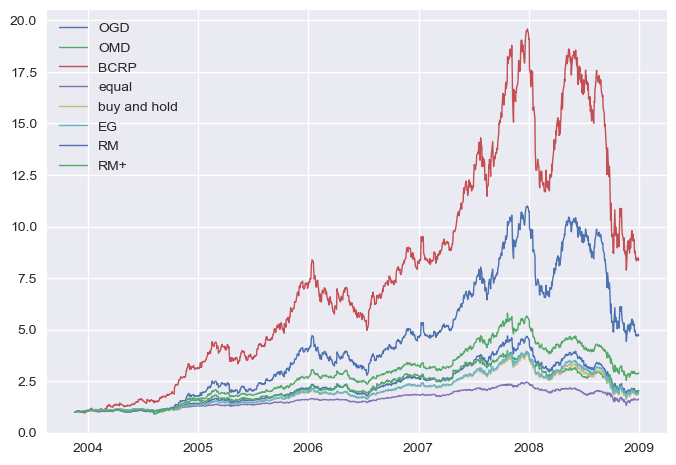

In [106]:
plt.figure()
plt.plot(df.index, arr_pfl_OGD[1:], linewidth=1, label='OGD')
plt.plot(df.index, arr_pfl_OMD[1:], linewidth=1, label='OMD')
plt.plot(df.index, arr_BCRP[1:], linewidth=1, label='BCRP')
plt.plot(df.index, arr_equal[1:], linewidth=1, label='equal')
# #plt.plot(df.index, arr_pfl_up, linewidth=1, label='up')
plt.plot(df.index, arr_pfl_BH, linewidth=1, label='buy and hold')
plt.plot(df.index, arr_pfl_EG[1:], linewidth=1, label='EG')
plt.plot(df.index, arr_pfl_RM[1:], linewidth=1, label='RM')
plt.plot(df.index, arr_pfl_RMPLUS[1:], linewidth=1, label='RM+')
plt.legend(loc='best')
plt.show()

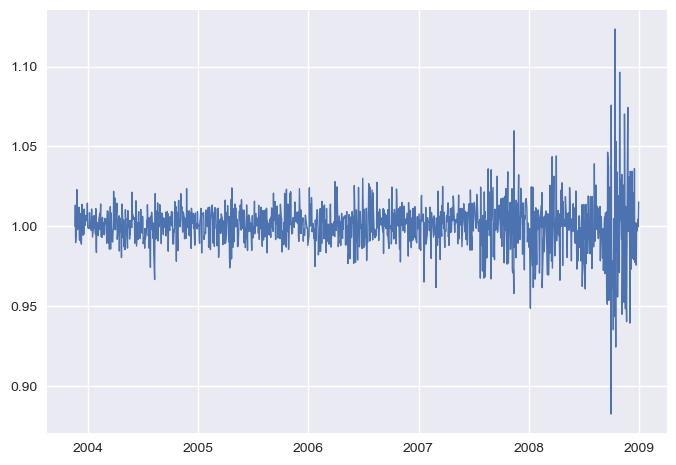

In [ ]:
plt.figure()
plt.plot(df.index, ret, linewidth=1, label='OGD')
plt.show()

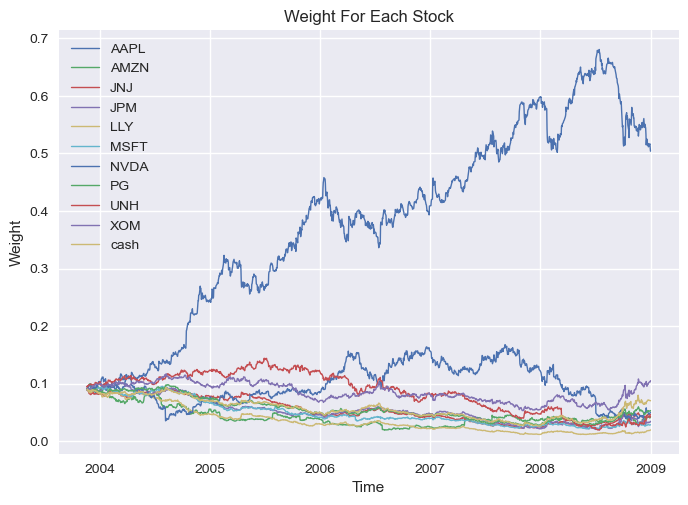

In [88]:
arr_stg = pd.DataFrame( arr_stg_EG[1:], columns=df.columns)

plt.figure()
for stk in arr_stg.columns:
    plt.plot(df.index, arr_stg.loc[:,stk], linewidth=1, label=stk)
    plt.legend(loc='best')

# plt.plot(df.index, arr_stg.loc[:,'cash'], linewidth=1, label=stk)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Weight')
plt.title('Weight For Each Stock')
plt.show()